## Importing SGMA Wells Data

In [2]:
import os
import ee
import geemap
import json

import pandas as pd
import numpy as np
import scipy
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry
import seaborn as sns

import fiona
import rasterio.mask
import descartes

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

import rasterio
from rasterio.transform import Affine


%matplotlib inline

pd.set_option('display.max_columns', None)


In [25]:
SGMA_GWE = pd.read_csv('SGMA_Elevation_16_17/GroundwaterElevation.csv')

#MSMT_DATE - Water Level Measurement Date (PST) 
#WSE – Water Surface Elevation (feet, above mean sea level)
#RPE_WSE - Reference Point Elevation to Water Surface Elevation
#GSE_WSE - Ground Surface Elevation to Water Surface Elevation
#WLM_RPE - RPE for specific water level measurement (WLM)
#WLM_GSE - GSE for specific water level measurement (WLM)
#RDNG_RP - Reading at Reference Point
#RDNG_WS - Reading at Water Surface

#WSE + RPE_WSE == WLM_RPE
#WSE + GSE_WSE == WLM_GSE
#RDNG_RP == RPE_WSE

print(SGMA_GWE.shape)
SGMA_GWE.head()

(957461, 22)


,SITE_CODE,WELL_NAME,SWN,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER
0,338552N1178566W001,AMD-1/MP10,NaN,47291,1995-10-27 11:00:00.0,116.788,101.91,103.34,218.698,220.128,101.91,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
1,338552N1178566W001,AMD-1/MP10,NaN,47291,2000-05-15 11:04:00.0,125.218,93.48,94.91,218.698,220.128,93.48,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
2,338552N1178566W003,AMD-1/MP5,NaN,47293,1990-09-12 11:07:00.0,75.398,143.30,144.73,218.698,220.128,143.30,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
3,338552N1178566W001,AMD-1/MP10,NaN,47291,2007-08-02 11:13:00.0,111.828,106.87,108.30,218.698,220.128,106.87,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
4,338649N1178024W001,AM-3,03S09W34J006S,47274,1996-05-10 11:20:00.0,247.387,28.20,28.91,275.587,276.297,28.20,0.0,5045,Orange County Water District,Electric sounder measurement,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com


In [26]:
#SGMA_GWE['ordinal'] = [pd.Timestamp.toordinal(x) for x in pd.to_datetime(SGMA_GWE.MSMT_DATE)]

# plot non-parametric kde on numeric datenum
#ax = SGMA_GWE['ordinal'].plot(kind='kde')
# rename the xticks with labels
#x_ticks = ax.get_xticks()
#ax.set_xticks(x_ticks[::2])
#xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
#ax.set_xticklabels(xlabels)

In [27]:
start_date = '01-01-2015'
SGMA_GWE.MSMT_DATE = pd.to_datetime(SGMA_GWE.MSMT_DATE)
SGMA_GWE_masked = SGMA_GWE.loc[SGMA_GWE['MSMT_DATE'] > start_date]
SGMA_GWE_masked.shape

(273287, 22)

In [28]:
#SGMA_GWE_masked['ordinal'] = [pd.Timestamp.toordinal(x) for x in pd.to_datetime(SGMA_GWE_masked.MSMT_DATE)]

# plot non-parametric kde on numeric datenum
#ax = SGMA_GWE_masked['ordinal'].plot(kind='kde')
# rename the xticks with labels
#x_ticks = ax.get_xticks()
#ax.set_xticks(x_ticks[::2])
#xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
#ax.set_xticklabels(xlabels)

In [29]:
SGMA_Station = pd.read_csv('SGMA_Elevation_16_17/Station.csv')

# WELL_DEPTH - Well Depth (feet bgs) 
# TOP_PRF - Top Perforation (feet bgs)       
# BOT_PRF -  Bottom Perforation (feet bgs)       
# GSE  -  Ground Surface Elevation    
# RPE  - Reference Point Elevation         
# RP_DESC  - Reference Point Description  

print(SGMA_Station.shape)
SGMA_Station.head()

(9768, 28)


,SITE_CODE,WELL_NAME,SWN,STN_ID,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO
0,347966N1165191W001,08N04E11K01,08N04E11K001S,38596,NaN,34.796650,-116.519932,5161.0,Mojave Water Agency,NaN,Unknown,Single Well,NaN,NaN,NaN,1809.897,1809.897,Unknown,NaN,2019-04-11 18:03:58.0,CLUDLUM_DBA,Digital Elevation Model,10 ft.,San Bernardino,South Lahontan,6-040,Lower Mojave River Valley,80238.0
1,355197N1192470W001,4D22I7,28S25E02K001M,39443,NaN,35.519700,-119.247000,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,377.490,378.490,None Provided,NaN,2017-11-03 18:02:50.0,DA LOAD,Unknown,Unknown,Kern,Tulare Lake,5-022.14,Kern County,80237.0
2,352027N1188996W001,RMW-041,31S29E30J001M,37594,NaN,35.199567,-118.898542,NaN,NaN,NaN,Irrigation,Single Well,NaN,NaN,NaN,376.000,376.000,ground surface,NaN,2020-01-25 11:05:32.0,bgooding,Digital Elevation Model,10 ft.,Kern,Tulare Lake,5-022.14,Kern County,80237.0
3,352969N1191471W001,6E261,30S26E26A001M,37631,NaN,35.296900,-119.147100,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,344.920,345.720,None Provided,NaN,2017-11-03 18:02:50.0,DA LOAD,Unknown,Unknown,Kern,Tulare Lake,5-022.14,Kern County,80237.0
4,359125N1194293W001,NaN,23S23E24J001M,37648,NaN,35.912500,-119.429300,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,205.700,205.700,None Provided,NaN,2017-11-03 18:02:50.0,DA LOAD,Unknown,Unknown,Tulare,Tulare Lake,5-022.13,Tule,80237.0


In [30]:
SGMA_Merged = pd.merge(SGMA_GWE_masked,SGMA_Station, how= 'left', on='STN_ID', suffixes = ('_GWE','_Station'))
print(SGMA_Merged.shape)
SGMA_Merged.head()

(273287, 49)


,SITE_CODE_GWE,WELL_NAME_GWE,SWN_GWE,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,SITE_CODE_Station,WELL_NAME_Station,SWN_Station,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO
0,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 11:00:00,19.39,164.15,164.55,183.54,183.94,164.15,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:41.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
1,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 13:00:00,19.70,163.84,164.24,183.54,183.94,163.84,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:43.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
2,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 14:00:00,19.82,163.72,164.12,183.54,183.94,163.72,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:45.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
3,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 21:00:00,18.17,165.37,165.77,183.54,183.94,165.37,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:47.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
4,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 05:00:00,18.68,164.86,165.26,183.54,183.94,164.86,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:49.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0


In [31]:
SGMA_Merged['SUB_SL'] = SGMA_Merged['WELL_DEPTH'] - SGMA_Merged['WLM_GSE']
SGMA_Merged['NET_WL'] = SGMA_Merged['SUB_SL'] + SGMA_Merged['WSE']

SGMA_Merged.head()

,SITE_CODE_GWE,WELL_NAME_GWE,SWN_GWE,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,SITE_CODE_Station,WELL_NAME_Station,SWN_Station,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO,SUB_SL,NET_WL
0,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 11:00:00,19.39,164.15,164.55,183.54,183.94,164.15,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:41.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.45
1,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 13:00:00,19.70,163.84,164.24,183.54,183.94,163.84,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:43.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.76
2,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 14:00:00,19.82,163.72,164.12,183.54,183.94,163.72,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:45.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.88
3,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 21:00:00,18.17,165.37,165.77,183.54,183.94,165.37,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:47.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,254.23
4,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 05:00:00,18.68,164.86,165.26,183.54,183.94,164.86,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:49.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,254.74


http://geologyandpython.com/ml-interpolation-method.html

In [32]:
SGMA_Merged['geometry'] = [geometry.Point(x, y) for x, y in zip(SGMA_Merged['LONGITUDE'], SGMA_Merged['LATITUDE'])]
SGMA_Merged_gpd = gpd.GeoDataFrame(SGMA_Merged, geometry='geometry', crs="epsg:4326")

SGMA_Merged_gpd.head()

,SITE_CODE_GWE,WELL_NAME_GWE,SWN_GWE,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,SITE_CODE_Station,WELL_NAME_Station,SWN_Station,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO,SUB_SL,NET_WL,geometry
0,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 11:00:00,19.39,164.15,164.55,183.54,183.94,164.15,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:41.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.45,POINT (-121.97582 36.99663)
1,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 13:00:00,19.70,163.84,164.24,183.54,183.94,163.84,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:43.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.76,POINT (-121.97582 36.99663)
2,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 14:00:00,19.82,163.72,164.12,183.54,183.94,163.72,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:45.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.88,POINT (-121.97582 36.99663)
3,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 21:00:00,18.17,165.37,165.77,183.54,183.94,165.37,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:47.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,254.23,POINT (-121.97582 36.99663)
4,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 05:00:00,18.68,164.86,165.26,183.54,183.94,164.86,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:49.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-Co

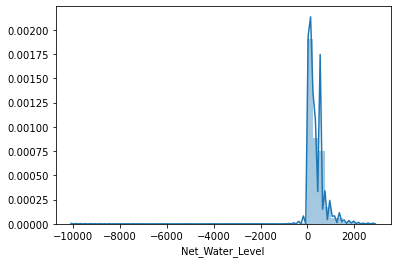

In [33]:
NET_WL = SGMA_Merged_gpd['NET_WL']

ax = sns.distplot(NET_WL, axlabel='Net_Water_Level')

In [34]:
NET_WL.loc[NET_WL < NET_WL.quantile(.001)] = np.nan
NET_WL.loc[NET_WL > NET_WL.quantile(.98)] = np.nan

vmin = 0
vmax = 1500

In [35]:
cmap = 'Spectral_r'
    
plt.style.use('seaborn-notebook')

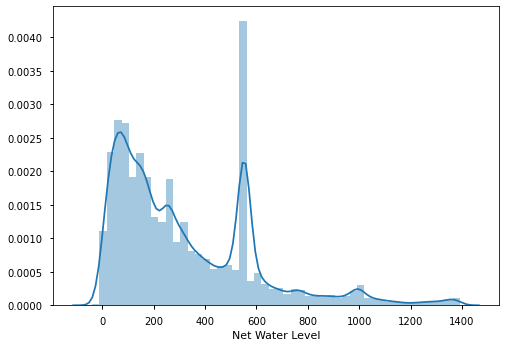

In [36]:
ax = sns.distplot(SGMA_Merged_gpd.NET_WL.dropna(), axlabel='Net Water Level')

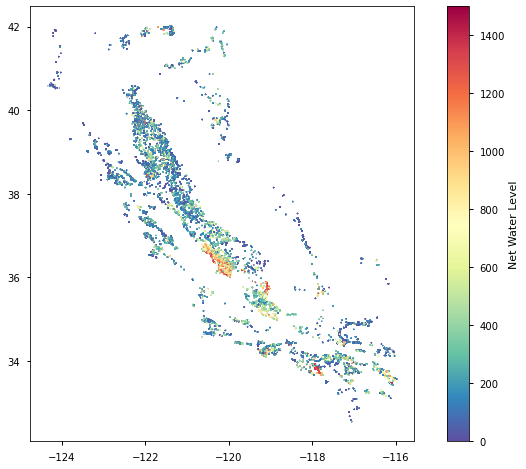

In [37]:
plt.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, cmap=cmap, s=1, c=NET_WL, vmin=vmin, vmax=vmax)
plt.colorbar(label=u'Net Water Level')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(12, 8)

In [38]:
shape_dest = '/home/aaron/Desktop/climate_maps/ca-state-boundary/CA_State_TIGER2016.shp'
shape_file = gpd.read_file(shape_dest)
shape_file = shape_file.to_crs('EPSG:4326')
shape_file.to_file('CA_bound_reproj.shp')

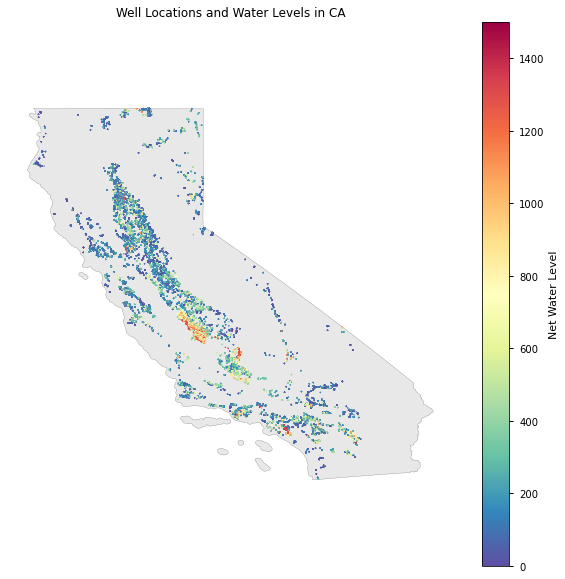

In [39]:
fig, ax = plt.subplots(figsize = (10, 10))

# first setup the plot using the crop_extent layer as the base layer 
shape_file.plot(color='lightgrey',
                      edgecolor = 'black',
                      ax = ax,
                      alpha=.5)


#ax.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, 
#           cmap=cmap, s=40, c=NET_WL, vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')

plt.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, cmap=cmap, s=1, c=NET_WL, vmin=vmin, vmax=vmax)
plt.colorbar(label=u'Net Water Level')

# add a title to the plot
ax.set_title('Well Locations and Water Levels in CA')
ax.set_axis_off()

plt.axis('equal')
plt.show()

In [40]:
pixel_size = 0.02
x_range = np.arange(SGMA_Merged_gpd.LONGITUDE.min() - SGMA_Merged_gpd.LONGITUDE.min() % pixel_size,
                    SGMA_Merged_gpd.LONGITUDE.max(), pixel_size)
y_range = np.arange(SGMA_Merged_gpd.LATITUDE.min() - SGMA_Merged_gpd.LATITUDE.min() % pixel_size,
                    SGMA_Merged_gpd.LATITUDE.max(), pixel_size)[::-1]

In [41]:
# CA Shapefile Extents
X_Min = shape_file.iloc[0].geometry.bounds[0] # Min Long (leftmost)
Y_Min = shape_file.iloc[0].geometry.bounds[1] # Min Lat (bottom)
X_Max = shape_file.iloc[0].geometry.bounds[2] # Max Long (rightmost)
Y_Max = shape_file.iloc[0].geometry.bounds[3] # Max Lat (top)
print(X_Min, X_Max, Y_Min, Y_Max)

-124.48201686078049 -114.13122247508855 32.52883673637251 42.00950826967187


In [42]:
# Set pixel size and range in x and y axes
pixel_size = 0.02
x_range = np.arange(X_Min - X_Min % pixel_size,
                    X_Max, pixel_size)
y_range = np.arange(Y_Min -  Y_Min % pixel_size,
                    Y_Max, pixel_size)[::-1]

In [43]:
# Set the shape and extent of the grid
shape = (len(y_range), len(x_range))
extent = xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

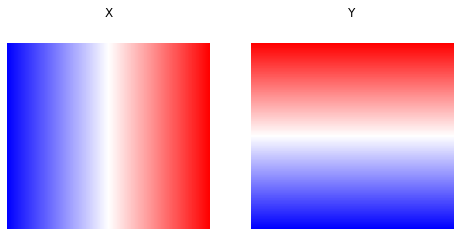

In [44]:
fig, axes = plt.subplots(1, 2)
for ax, data, title in zip(axes.ravel(), [x_mesh, y_mesh], ['X', 'Y']):
    ax.matshow(data, extent=extent, cmap='bwr'); ax.set_axis_off(); ax.set_title(title)

In [45]:
SGMA_Merged_gpd.loc[:, 'X_INDEX'] = ((SGMA_Merged_gpd.LONGITUDE - xmin) / pixel_size).astype(int)
SGMA_Merged_gpd.loc[:, 'Y_INDEX'] = (shape[0] - ((SGMA_Merged_gpd.LATITUDE - ymin) / pixel_size)).astype(int)

In [46]:
# Create a numpy array to fill with the net water level values according to pixels

SGMA_array = np.zeros(shape)
SGMA_array[:] = np.nan
SGMA_array[SGMA_Merged_gpd.Y_INDEX, SGMA_Merged_gpd.X_INDEX] = NET_WL 
SGMA_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

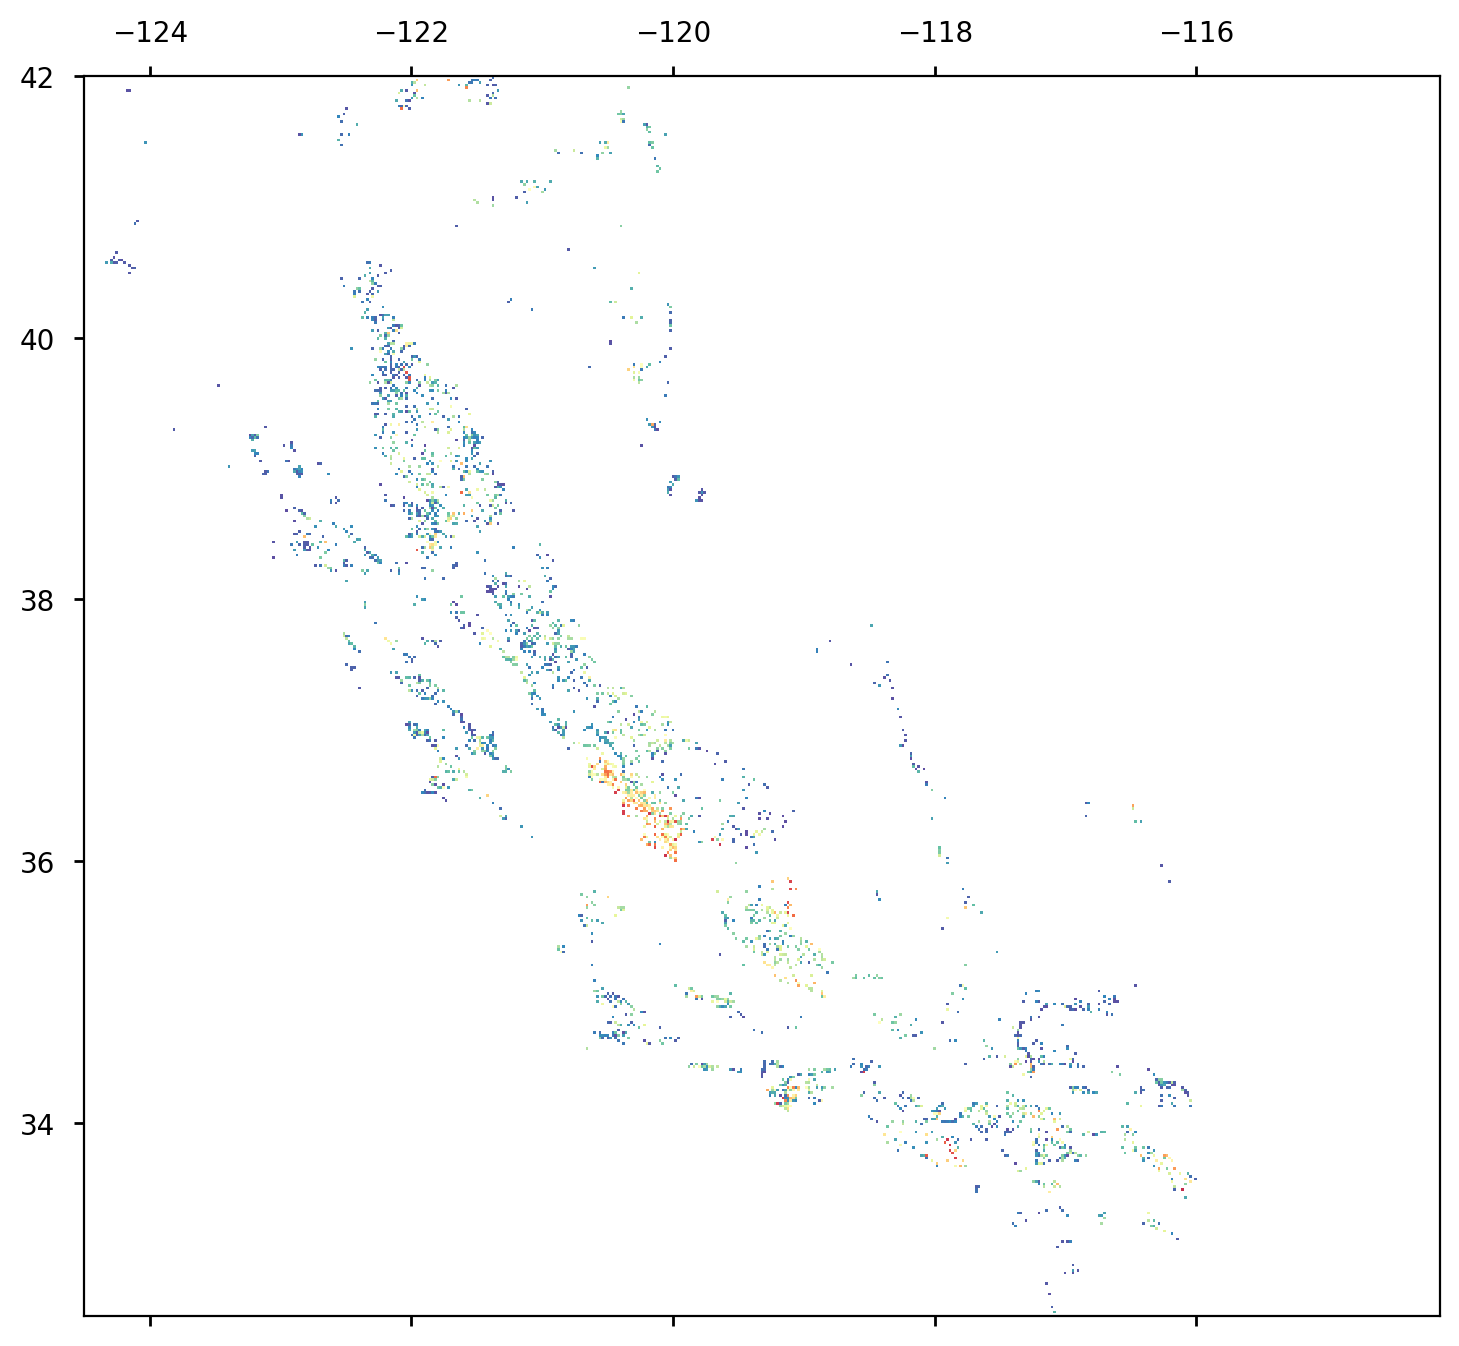

In [47]:
# Visualize the numpy array as pixels in a map

plt.matshow(SGMA_array, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(200)

In [48]:
# Copy SGMA_array with subset of pixels set to nan as holdout test set
# Use test set pixels for accuracy assessment later

# https://datascience.stackexchange.com/questions/30245/is-there-a-way-to-replace-existing-values-with-nan

import random

def_points = np.vstack([np.where(np.isfinite(SGMA_array))]).T
test_ratio = 0.2
# Edit: changed len(mat) for mat.size
test_num = int(def_points.shape[0] * test_ratio)

# Randomly choose indices of the numpy array:
test_point_index = random.sample(range(def_points.shape[0]),test_num)
test_point_positions = def_points[test_point_index,:]

SGMA_array_train = np.ndarray.copy(SGMA_array)

for i in range(test_point_positions.shape[0]):
    SGMA_array_train[test_point_positions[i][0],test_point_positions[i][1]] = np.NaN

SGMA_array_test = np.empty(SGMA_array.shape)
SGMA_array_test[:] = np.nan

for i in range(test_point_positions.shape[0]):
    SGMA_array_test[test_point_positions[i][0],test_point_positions[i][1]] = SGMA_array[test_point_positions[i][0],test_point_positions[i][1]]

627


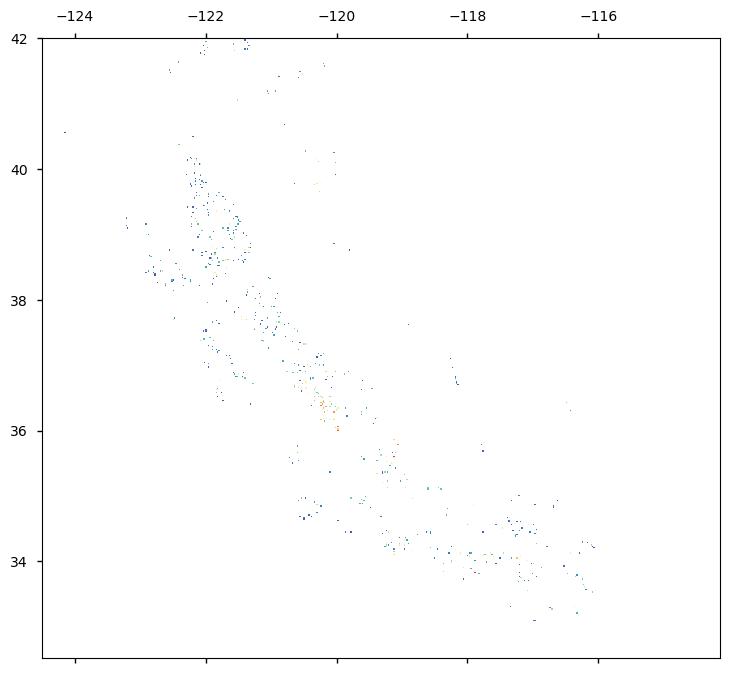

In [49]:
plt.matshow(SGMA_array_test, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(100)
print(np.isfinite(SGMA_array_test).sum())

2509


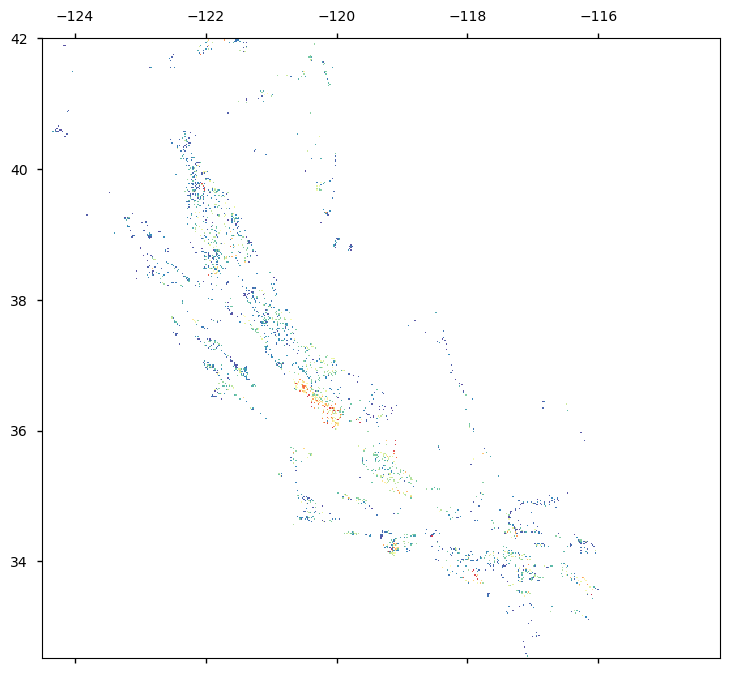

In [50]:
plt.matshow(SGMA_array_train, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(100)
print(np.isfinite(SGMA_array_train).sum())

### Predict Interpolated Raster Pixels with Machine Learning

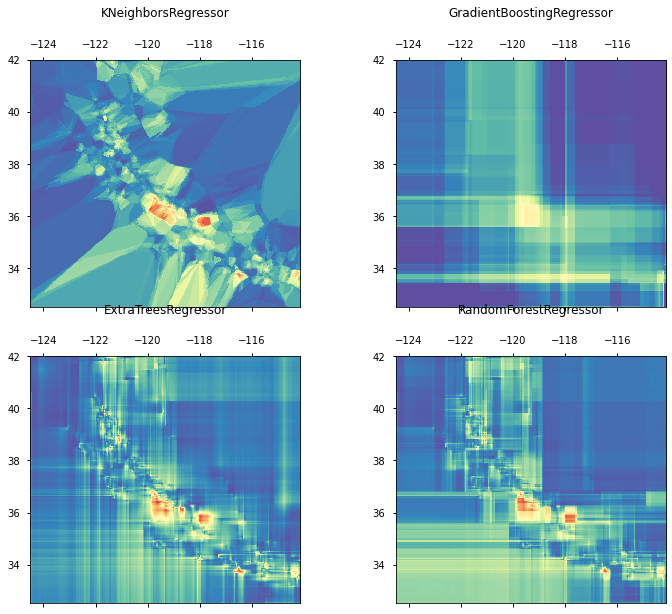

In [51]:
regrs = [KNeighborsRegressor(),
        GradientBoostingRegressor(),
        ExtraTreesRegressor(),
        RandomForestRegressor()
       ]

preds_2d = {}

y_fit = SGMA_array_train[np.isfinite(SGMA_array_train)]
x_index_fit, y_index_fit = np.where(np.isfinite(SGMA_array_train))
x_index_pred, y_index_pred = np.where(SGMA_array_train)

X_fit = MinMaxScaler().fit_transform(np.vstack([x_index_fit, y_index_fit]).T)
X_pred = MinMaxScaler().fit_transform(np.vstack([x_index_pred, y_index_pred]).T)

fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, regr, title in zip(axes.ravel(),
                          regrs,
                          ['KNeighborsRegressor', 
                           'GradientBoostingRegressor', 
                           'ExtraTreesRegressor', 
                           'RandomForestRegressor']):

    regr.fit(X=X_fit, y=y_fit)
    y_pred = regr.predict(X=X_pred)
    preds_2d[title] = y_pred
    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, y=1.15)

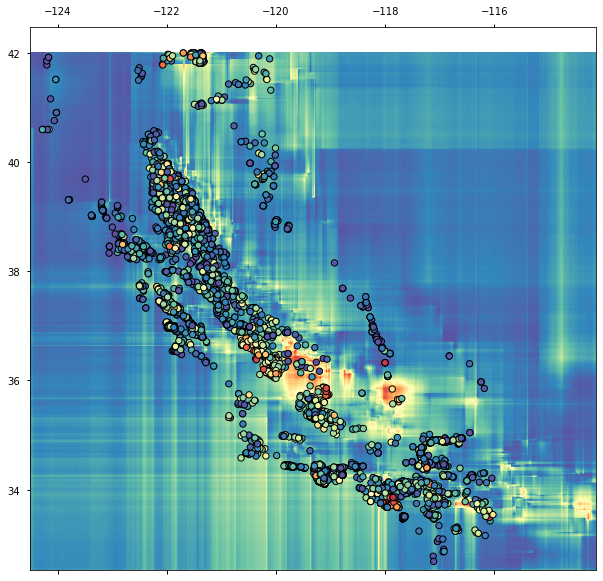

In [52]:
NET_WL_RF_2d = preds_2d['RandomForestRegressor'].reshape(shape)
NET_WL_ETF_2d = preds_2d['ExtraTreesRegressor'].reshape(shape)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(NET_WL_ETF_2d, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
ax.scatter(SGMA_Merged_gpd.LONGITUDE[::25], SGMA_Merged_gpd.LATITUDE[::25], 
           cmap=cmap, s=40, c=NET_WL[::25], vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')

In [54]:
# Compare interpolated arrays with original numpy pixel array on mean squared error and r-squared
# Train set accuracy

RF_2d_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array_train)] - NET_WL_RF_2d[np.isfinite(SGMA_array_train)])**2)
ETF_2d_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array_train)] - NET_WL_ETF_2d[np.isfinite(SGMA_array_train)])**2)

RF_2d_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array_train)], NET_WL_RF_2d[np.isfinite(SGMA_array_train)])
ETF_2d_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array_train)], NET_WL_ETF_2d[np.isfinite(SGMA_array_train)])

RF_2d_R2 = RF_2d_R[0,1]**2
ETF_2d_R2 = ETF_2d_R[0,1]**2

print("RF MSE:",RF_2d_MSE)
print("ETF MSE:",ETF_2d_MSE)
print("RF R-Squared:",RF_2d_R2)
print("ETF R-Squared:",ETF_2d_R2)

RF MSE: 100611.89739203034
ETF MSE: 97911.78769491655
RF R-Squared: 0.027063756720680007
ETF R-Squared: 0.03966816237225019


In [55]:
# Compare interpolated arrays with original numpy pixel array on mean squared error and r-squared
# Test set accuracy

RF_2d_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array_test)] - NET_WL_RF_2d[np.isfinite(SGMA_array_test)])**2)
ETF_2d_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array_test)] - NET_WL_ETF_2d[np.isfinite(SGMA_array_test)])**2)

RF_2d_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array_test)], NET_WL_RF_2d[np.isfinite(SGMA_array_test)])
ETF_2d_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array_test)], NET_WL_ETF_2d[np.isfinite(SGMA_array_test)])

RF_2d_R2 = RF_2d_R[0,1]**2
ETF_2d_R2 = ETF_2d_R[0,1]**2

print("RF MSE:",RF_2d_MSE)
print("ETF MSE:",ETF_2d_MSE)
print("RF R-Squared:",RF_2d_R2)
print("ETF R-Squared:",ETF_2d_R2)

RF MSE: 95031.59762296868
ETF MSE: 90680.08661060216
RF R-Squared: 0.020294576964363972
ETF R-Squared: 0.03431370356672162


In [56]:
n_angles = 60

X_var, Y_var, angle = np.meshgrid(x_range, y_range, n_angles)

angles = np.deg2rad(np.linspace(0, 180, n_angles, endpoint=False))

X = X_var + np.tan(angles) * Y_var

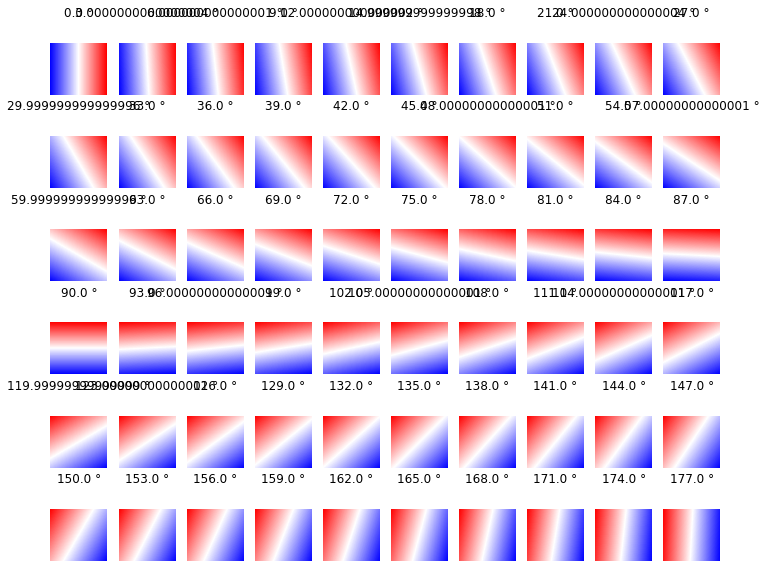

In [57]:
X[:,:,np.int((n_angles/2)+1):] = np.flipud(np.fliplr(X[:,:,np.int((n_angles/2)+1):]))

fig, axes = plt.subplots(6, 10, figsize=(12, 10))
for ax, data, angle in zip(axes.ravel(), np.dsplit(X, 60), angles):
    ax.matshow(data.squeeze(), extent=extent, cmap='bwr'); ax.set_axis_off()
    ax.set_title(u'{} °'.format(str(np.rad2deg(angle))))

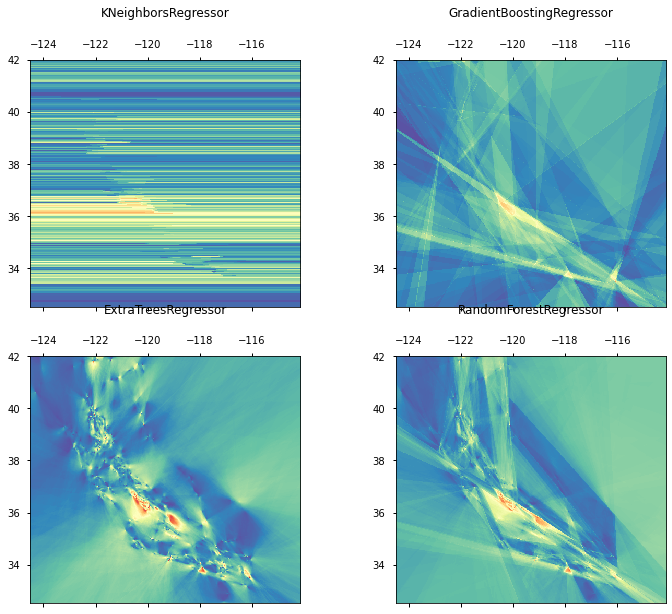

In [58]:
X_fit = X[x_index_fit, y_index_fit]

X_pred = X.reshape(-1, 60)
preds = {}
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, regr, title in zip(axes.ravel(),
                          regrs,
                            ['KNeighborsRegressor',
                             'GradientBoostingRegressor', 
                             'ExtraTreesRegressor', 
                             'RandomForestRegressor']):

    regr.fit(X=X_fit, y=y_fit)
    y_pred = regr.predict(X=X_pred)
    preds[title] = y_pred
    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, y=1.15)

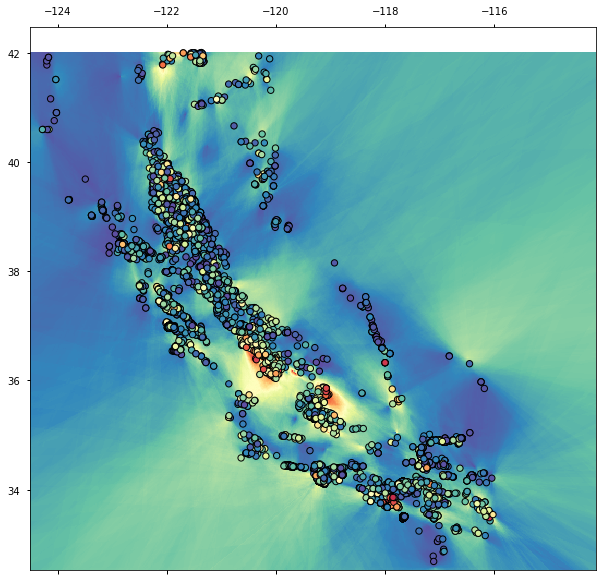

In [59]:
NET_WL_RF = preds['RandomForestRegressor'].reshape(shape)
NET_WL_ETF = preds['ExtraTreesRegressor'].reshape(shape)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(NET_WL_ETF, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
ax.scatter(SGMA_Merged_gpd.LONGITUDE[::25], SGMA_Merged_gpd.LATITUDE[::25], 
           cmap=cmap, s=40, c=NET_WL[::25], vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')

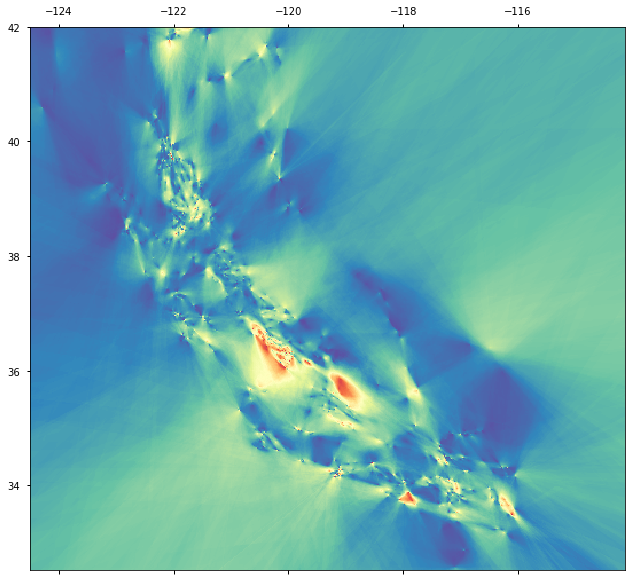

In [60]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(NET_WL_ETF, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
## Correct Projection

In [61]:
# Compare interpolated arrays with original numpy pixel array on mean squared error and r-squared
RF_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array_test)] - NET_WL_RF[np.isfinite(SGMA_array_test)])**2)
ETF_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array_test)] - NET_WL_ETF[np.isfinite(SGMA_array_test)])**2)

RF_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array_test)], NET_WL_RF[np.isfinite(SGMA_array_test)])
ETF_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array_test)], NET_WL_ETF[np.isfinite(SGMA_array_test)])

RF_R2 = RF_R[0,1]**2
ETF_R2 = ETF_R[0,1]**2

print("RF MSE:",RF_MSE)
print("ETF MSE:",ETF_MSE)
print("RF R-Squared:",RF_R2)
print("ETF R-Squared:",ETF_R2)

RF MSE: 52636.08084589995
ETF MSE: 59291.46911640664
RF R-Squared: 0.36292764701517743
ETF R-Squared: 0.3380093955501196


In [62]:
res = (X_Max - X_Min) / NET_WL_ETF.shape[1] # East-most point minus west-most point; X_Max - X_Min
transform = Affine.translation(X_Min - res / 2, Y_Min - res / 2) * Affine.scale(res, res)
print(res)
transform

0.019943727140061544


Affine(0.019943727140061544, 0.0, -124.49198872435052,
       0.0, 0.019943727140061544, 32.51886487280248)

In [63]:
crs = rasterio.crs.CRS.from_epsg(4326)

In [64]:
new_dataset = rasterio.open(
'/tmp/new.tif',
'w',
driver='GTiff',
height=NET_WL_ETF.shape[0], #rows in the dataset
width=NET_WL_ETF.shape[1], #columns in the dataset
count=1,
dtype=NET_WL_ETF.dtype,
crs=crs,
transform=transform,
nodata=np.nan)

In [65]:
# Flip dataset upside down again to correct the transformation

new_dataset.write(np.flipud(NET_WL_ETF),1)
new_dataset.close()

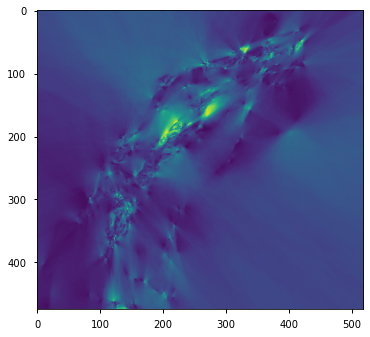

In [66]:
# Upside down for some reason, probably the affine transformation
test_dataset = rasterio.open('/tmp/new.tif', 
                             driver='GTiff',
                             height=NET_WL_ETF.shape[0],
                             width=NET_WL_ETF.shape[1],
                             count=1,
                             dtype=NET_WL_ETF.dtype,
                             crs=crs)

plt.imshow(test_dataset.read(1),cmap='viridis')
plt.show()

### Mask out CA Boundary

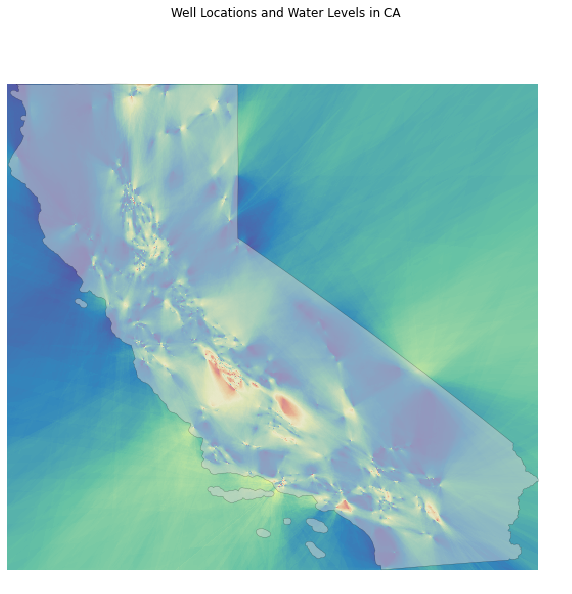

In [67]:
fig, ax = plt.subplots(figsize = (10, 10))

# first setup the plot using the crop_extent layer as the base layer 
shape_file.plot(color='lightgrey',
                      edgecolor = 'black',
                      ax = ax,
                      alpha=.5)
# then add another layer using geopandas syntax .plot, and calling the ax variable as the axis argument


#ax.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, 
#           cmap=cmap, s=40, c=NET_WL, vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')


ax.matshow(NET_WL_ETF, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)

# add a title to the plot
ax.set_title('Well Locations and Water Levels in CA')
ax.set_axis_off()
plt.axis('equal')
plt.show()


In [68]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/
#from rasterio.plot import plotting_extent

#import earthpy as et
#import earthpy.spatial as es
#import earthpy.plot as ep

#with rasterio.open('/tmp/new.tif', crs = crs) as src:
#    raster_crop, raster_crop_meta = es.crop_image(src, shape_file)

#raster_crop_affine = raster_crop_meta["transform"]

# Create spatial plotting extent for the cropped layer
#raster_extent = plotting_extent(raster_crop[0], raster_crop_affine)

In [69]:
# Plot your data
#ep.plot_bands(raster_crop[0],
#              extent=raster_extent,
#              cmap='Greys',
#              title="Cropped Raster Dataset",
#              scale=False)
#plt.show()

In [70]:
# Somehow flipped CA upside down
#fig = plt.figure(figsize=(15, 10))
#ax = fig.add_subplot(111)
#ax.matshow(raster_crop[0,:,:], extent=raster_extent, cmap=cmap, vmin=vmin, vmax=vmax)


In [71]:
with fiona.open('CA_bound_reproj.shp', "r") as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]

In [72]:
with rasterio.open('/tmp/new.tif', crs = crs) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta.copy()
    
out_meta.update({'driver':'GTiff',
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform,
                'nodata': None})

with rasterio.open('wells_masked.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

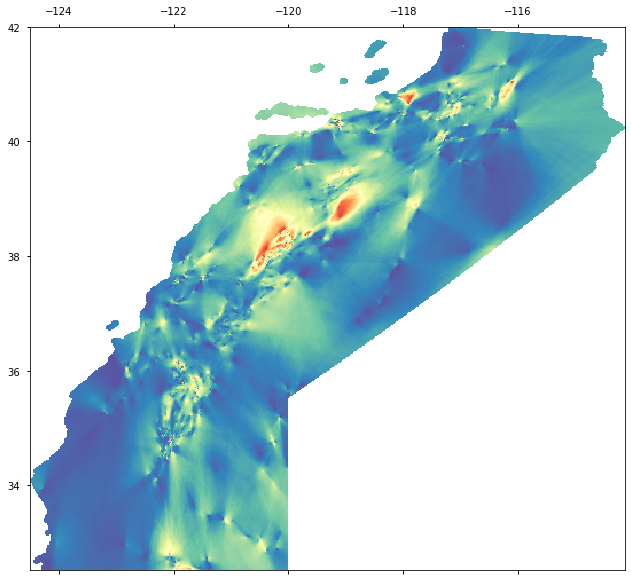

In [73]:
# Somehow flipped CA upside down
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(out_image[0,:,:], extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)

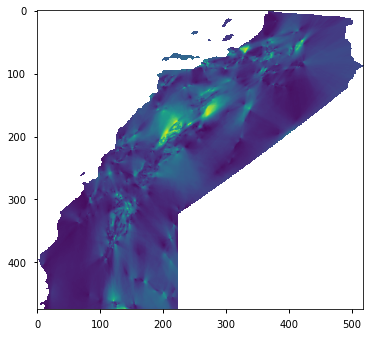

In [74]:
out_test_dataset = rasterio.open('wells_masked.tif', 
                             driver='GTiff',
                             height=out_image.shape[1],
                             width=out_image.shape[2],
                             count=1,
                             dtype=out_image.dtype)

plt.imshow(out_test_dataset.read(1),cmap='viridis')
plt.show()

## Add SGMA Data to GEE

In [4]:
ee.Initialize()

In [5]:
#SGMA_Map = geemap.Map()
#SGMA_Map.add_raster('wells_masked.tif', colormap='viridis', layer_name='SGMA_Interpolated')
# SGMA_Map.add_raster('/tmp/new.tif', colormap='viridis',layer_name='Temp Raster') #Unmasked data
#SGMA_Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [ ]:
# Min-Max scale the SGMA data to make it comparable with PDSI

## GEEMAP Visualizations

In [6]:
ca_bound = ee.FeatureCollection('users/theaaronscherf/ca-state-boundary')
CA_Map = geemap.Map()
CA_Map.addLayer(ca_bound)

In [7]:
farmview_data = ee.FeatureCollection('users/theaaronscherf/own_cropland')
CA_Map.addLayer(farmview_data)
CA_Map.centerObject(ca_bound, zoom=6)
CA_Map

Map(center=[37.15243771573542, -119.5265626992281], controls=(WidgetControl(options=['position'], widget=HBox(…

In [8]:
# Limit farmview parcels to those with an acreage greater than 0.1

farmview_filtered = farmview_data.filter(ee.Filter.gt('acres', 20))

farm_map = geemap.Map()
farm_map.addLayer(farmview_filtered)
farm_map.centerObject(farmview_filtered,zoom=8)
farm_map

Map(center=[36.380383283179775, -121.23047933681629], controls=(WidgetControl(options=['position'], widget=HBo…

In [435]:
farmview_filtered.size().getInfo()

8313

In [392]:
Acreage_Map = geemap.Map()
empty = ee.Image().float()
palette = ['FF0000', '00FF00', '0000FF']
viz = {'min':1, 'max':1000, 'palette':palette}


fills = empty.paint(featureCollection = farmview_data,color='crop_acres')
Acreage_Map.centerObject(farmview_data, 10)
Acreage_Map.addLayer(fills, viz,'crop acreage')
Acreage_Map

Map(center=[36.386816818707885, -121.23547940313944], controls=(WidgetControl(options=['position'], widget=HBo…

In [393]:
Map = geemap.Map()

NLCD2016 = ee.Image('USGS/NLCD/NLCD2016').select('landcover')
nlcd_vis = {
    'bands': ['landcover']
}

Map.addLayer(NLCD2016, nlcd_vis, 'landcover')

In [394]:
Private = farmview_data \
    .filter(ee.Filter.eq("public_pri", 'private')) 

Public = farmview_data \
    .filter(ee.Filter.eq("public_pri", 'public')) 

Map.centerObject(farmview_data, 10)
Map.addLayer(Private, {'opacity':0.5}, 'private')
Map.addLayer(Public, {'opacity':0.5}, 'public')
Map

Map(center=[36.386816818707885, -121.23547940313944], controls=(WidgetControl(options=['position'], widget=HBo…

In [395]:
#out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
#nlcd_stats = os.path.join(out_dir, 'nlcd_stats.csv')  

# statistics_type can be either 'SUM' or 'PERCENTAGE'
# denominator can be used to convert square meters to other areal units, such as square kilimeters
#geemap.zonal_statistics_by_group(NLCD2016, farmview_data, nlcd_stats, statistics_type='SUM', denominator=1000000, decimal_places=2)

In [9]:
collection = ee.ImageCollection('GRIDMET/DROUGHT')

#Filter by date
dS = '2017-01-30'
dE = '2017-01-30'
dSUTC = ee.Date(dS, 'GMT')
dEUTC = ee.Date(dE, 'GMT')
filtered = collection.filterDate(dSUTC, dEUTC.advance(365, 'day'))

# Select variables pdsi and z
PDSI = filtered.select('pdsi')

# Make a color palette that is similar to USDM drought classification
usdmColors = "0000aa,0000ff,00aaff,00ffff,aaff55,ffffff,ffff00,fcd37f,ffaa00,e60000,730000";

# Make color options for Palmer variables psdi/z
minColorbar= -6
maxColorbar= 6
colorbarOptions2 = {
  'min':minColorbar,
  'max':maxColorbar,
  'palette': usdmColors
}

av_PDSI = ee.Image(PDSI.mean())
CA_PDSI = av_PDSI.clip(ca_bound)

# Add map layers to Google Map
pdsi_Map = geemap.Map()
pdsi_Map.addLayer(CA_PDSI, colorbarOptions2, 'PDSI');
pdsi_Map.centerObject(ca_bound, zoom=6)
pdsi_Map

Map(center=[37.15243771573542, -119.5265626992281], controls=(WidgetControl(options=['position'], widget=HBox(…

In [403]:
# Download PDSI image of CA as raster GeoTIFF file
# https://github.com/giswqs/geemap/blob/master/examples/notebooks/11_export_image.ipynb

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'CA_PDSI.tif')
ca_geom = ca_bound.geometry()

In [412]:
image = CA_PDSI.unmask()
# geemap.ee_export_image(image, filename=filename, scale=200, region=ca_geom, file_per_band=False)

Generating URL ...
An error occurred while downloading.
Total request size (121647344 bytes) must be less than or equal to 33554432 bytes.


In [437]:
geemap.ee_export_image_to_drive(image, description='ca_pdsi_coll', folder='export', region=ca_geom, scale=100)

Exporting ca_pdsi_coll ...


In [20]:
# Download raster file from Drive to local machine and import to Python
crs = rasterio.crs.CRS.from_epsg(4326)
# Open and mask PDSI raster

with rasterio.open('ca_pdsi.tif', crs = crs) as src:
    out_pdsi_image, out_pdsi_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_pdsi_meta = src.meta.copy()
    
out_pdsi_meta.update({'driver':'GTiff',
                'height': out_pdsi_image.shape[1],
                'width': out_pdsi_image.shape[2],
                'transform': out_pdsi_transform})

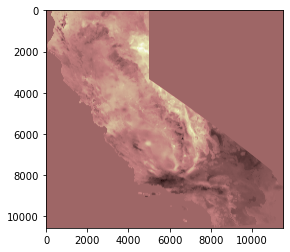

In [21]:
with rasterio.open('pdsi_masked.tif', 'w', **out_pdsi_meta) as dest:
    dest.write(out_pdsi_image)

ca_pdsi_raster = rasterio.open('pdsi_masked.tif', 
                             driver='GTiff',
                             height=out_pdsi_image.shape[1],
                             width=out_pdsi_image.shape[2],
                             count=1,
                             dtype=out_pdsi_image.dtype)

plt.imshow(ca_pdsi_raster.read(1),cmap='pink')
plt.show()

In [9]:
SGMA_Map.add_raster('ca_pdsi.tif', colormap='pink', layer_name='PDSI')

SGMA_Map

Map(bottom=1826.0, center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(Togg…

## Calculate Combined Groundwater-Drought Layer

In [15]:
# Convert PDSI raster layer to numpy array and coerce to bounding dimensions of SGMA data

#pdsi_array = ca_pdsi_raster.read(1)

# How to rescale PDSI data?

# Maybe easier to calculate in GEE using pyramid system?

SGMA_viz = {
  'min': 0.0,
  'max': 800.0,
  'palette': [
    '1a3678', '2955bc', '5699ff', '8dbae9', 'acd1ff', 'caebff', 'e5f9ff',
    'fdffb4', 'ffe6a2', 'ffc969', 'ffa12d', 'ff7c1f', 'ca531a', 'ff0000',
    'ab0000'
  ],
}

sgma_ee_image = ee.Image('users/theaaronscherf/wells_masked_2')
pdsi_Map.addLayer(sgma_ee_image, SGMA_viz,'SGMA_Interpolated')
pdsi_Map

Map(bottom=6643.0, center=[37.15243771573542, -119.5265626992281], controls=(WidgetControl(options=['position'…

In [21]:
# Min-Max scale PDSI layer
# PDSI ranges from -15 (driest) to 15 (wettest)

scaled_PDSI = CA_PDSI.expression(
    '(PDSI - min(PDSI)) / (max(PDSI) - min(PDSI))' {
      'PDSI': CA_PDSI.select('pdsi')
})


SyntaxError: invalid syntax (<ipython-input-21-31efd6b42d19>, line 5)

In [30]:
CA_PDSI.select('pdsi').getInfo()

{'type': 'Image',
 'bands': [{'id': 'pdsi',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
# SGMA layer records well water levels as floats, so higher numbers indicate more groundwater
# Adding SGMA scaled data to PDSI data will reflect groundwater mitigation of dry areas as well as aggregation in wet areas



In [ ]:
# Visualize resulting combined layer

In [ ]:
# Calculate zonal statistics for Farmview data

#### Side-by-Side map of NAIP timeseries

In [12]:
naip_ts = geemap.naip_timeseries(start_year=2009, end_year=2018, roi=ca_bound)

In [13]:
layer_names = ['NAIP ' + str(year) for year in range(2009, 2019)]
naip_vis = {'bands': ['N', 'R', 'G']}

Create a split-panel map for visualizing NAIP imagery. Use the dropdown menus in the top corners to select the layer years.

In [14]:
naip_Map = geemap.Map()
naip_Map.ts_inspector(left_ts=naip_ts, right_ts=naip_ts, left_names=layer_names, right_names=layer_names, left_vis=naip_vis, right_vis=naip_vis)
naip_Map.centerObject(ca_bound, zoom=6)
naip_Map

Map(center=[37.15243771573526, -119.5265626992281], controls=(WidgetControl(options=['position'], widget=Dropd…